# Telecom Churn Case Study

With 21 predictor variables we need to predict whether a particular customer will switch to another telecom provider or not. In telecom terminology, this is referred to as churning and not churning, respectively.

### Importing necessary libraries

In [1]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load datasets

In [2]:
# load datasets

churn_data = pd.read_csv('churn_data.csv')
customer_data = pd.read_csv('customer_data.csv')
internet_data = pd.read_csv('internet_data.csv')

In [3]:
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


In [6]:
print(churn_data.shape)
print(internet_data.shape)
print(customer_data.shape)

(7043, 9)
(7043, 9)
(7043, 5)


### Merge datasets

In [7]:
# merge the datasets into single master data

temp_df = pd.merge(left = churn_data, right = customer_data, on = 'customerID')
telecom_data = pd.merge(left = temp_df, right = internet_data, on = 'customerID')

In [8]:
telecom_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [9]:
telecom_data.shape

(7043, 21)

In [10]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


In [11]:
telecom_data.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [12]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


### Data preparation

In [13]:
# handle binary variables

binary_vars = ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']
telecom_data[binary_vars] = telecom_data[binary_vars].apply(lambda x: x.map({'Yes': 1, 'No': 0}))
telecom_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,...,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,0,0,No,Fiber optic,No,No,No,No,No,No


In [14]:
# handling categorical variables

categorical_vars = ['Contract', 'PaymentMethod', 'gender', 'InternetService']

telecom_data = pd.get_dummies(data=telecom_data, columns=categorical_vars, dtype='int32', drop_first=True)

Since rest of the categorical columns has same level **No phone service** with count 1526 and variable `InternetService` with level as **No** also has count 1526. Hence we can conclude that the level **No phone service** is redundant for all of the variables so instead of `drop_first=True` we need to remove it.

In [15]:
categorical_vars = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies']

telecom_data = pd.get_dummies(data = telecom_data, columns = categorical_vars, dtype='int32')

In [16]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7043 non-null   object 
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   int32  
 11  Cont

In [17]:
redundant_vars = []

for s in categorical_vars:
    if s == 'MultipleLines':
        s += '_No phone service'
    else: s += '_No internet service'
    redundant_vars.append(s)
    
telecom_data = telecom_data.drop(columns=redundant_vars, axis = 1)

In [18]:
telecom_data['TotalCharges'] = pd.to_numeric(telecom_data['TotalCharges'], errors='coerce')

In [19]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   int64  
 3   PaperlessBilling                       7043 non-null   int64  
 4   MonthlyCharges                         7043 non-null   float64
 5   TotalCharges                           7032 non-null   float64
 6   Churn                                  7043 non-null   int64  
 7   SeniorCitizen                          7043 non-null   int64  
 8   Partner                                7043 non-null   int64  
 9   Dependents                             7043 non-null   int64  
 10  Contract_One year                      7043 non-null   int32  
 11  Cont

In [20]:
# handling missing values

round(telecom_data.isnull().mean() * 100, 2)

customerID                               0.00
tenure                                   0.00
PhoneService                             0.00
PaperlessBilling                         0.00
MonthlyCharges                           0.00
TotalCharges                             0.16
Churn                                    0.00
SeniorCitizen                            0.00
Partner                                  0.00
Dependents                               0.00
Contract_One year                        0.00
Contract_Two year                        0.00
PaymentMethod_Credit card (automatic)    0.00
PaymentMethod_Electronic check           0.00
PaymentMethod_Mailed check               0.00
gender_Male                              0.00
InternetService_Fiber optic              0.00
InternetService_No                       0.00
MultipleLines_No                         0.00
MultipleLines_Yes                        0.00
OnlineSecurity_No                        0.00
OnlineSecurity_Yes                

In [21]:
# drop missing values of TotalCharges

telecom_data = telecom_data[~telecom_data['TotalCharges'].isnull()]

In [22]:
round(telecom_data.isnull().mean() * 100, 2)

customerID                               0.0
tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
MultipleLines_No                         0.0
MultipleLines_Yes                        0.0
OnlineSecurity_No                        0.0
OnlineSecurity_Yes                       0.0
OnlineBack

In [23]:
# Split test and train data by 70-30 rule

train_data, test_data = train_test_split(telecom_data, train_size=0.7, random_state=100)
print(train_data.shape)
print(test_data.shape)

(4922, 32)
(2110, 32)


In [24]:
# rescaling the features by standard scaling

scaler = StandardScaler()
scaler.fit(train_data[['tenure', 'MonthlyCharges', 'TotalCharges']])
train_data[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(train_data[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [25]:
train_data.describe()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,Contract_One year,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
count,4.922000e+03,4922.000000,4922.000000,4.922000e+03,4.922000e+03,4922.000000,4922.000000,4922.000000,4922.000000,4922.000000,...,4922.000000,4922.000000,4922.000000,4922.000000,4922.000000,4922.000000,4922.00000,4922.000000,4922.000000,4922.00000
mean,7.506750e-17,0.903901,0.591223,-2.064356e-16,1.183757e-16,0.261479,0.161926,0.480699,0.297237,0.214953,...,0.431735,0.351280,0.440471,0.342544,0.485575,0.297440,0.40065,0.382365,0.395165,0.38785
std,1.000102e+00,0.294757,0.491658,1.000102e+00,1.000102e+00,0.439485,0.368420,0.499678,0.457088,0.410832,...,0.495368,0.477419,0.496494,0.474609,0.499843,0.457178,0.49008,0.486014,0.488936,0.48731
min,-1.286319e+00,0.000000,0.000000,-1.548555e+00,-1.002408e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
25%,-9.598159e-01,1.000000,0.000000,-9.665930e-01,-8.344722e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
50%,-1.435582e-01,1.000000,1.000000,1.823658e-01,-3.877341e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
75%,9.583897e-01,1.000000,1.000000,8.341630e-01,6.589888e-01,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000
max,1.611396e+00,1.000000,1.000000,1.793569e+00,2.818847e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000


In [26]:
# create X_train and y_train

X_train = train_data.drop(columns=['customerID', 'Churn'])
y_train = train_data['Churn']

In [27]:
# check balancing in y_train => as it is binary catrgorical so 0/1 value should be balanced i.e. in 50%-50% ratio

(sum(y_train) / len(y_train))*100

26.147907354733846

Balancing is 26.15% which is neither bad nor good so we can move forward.

### Model building

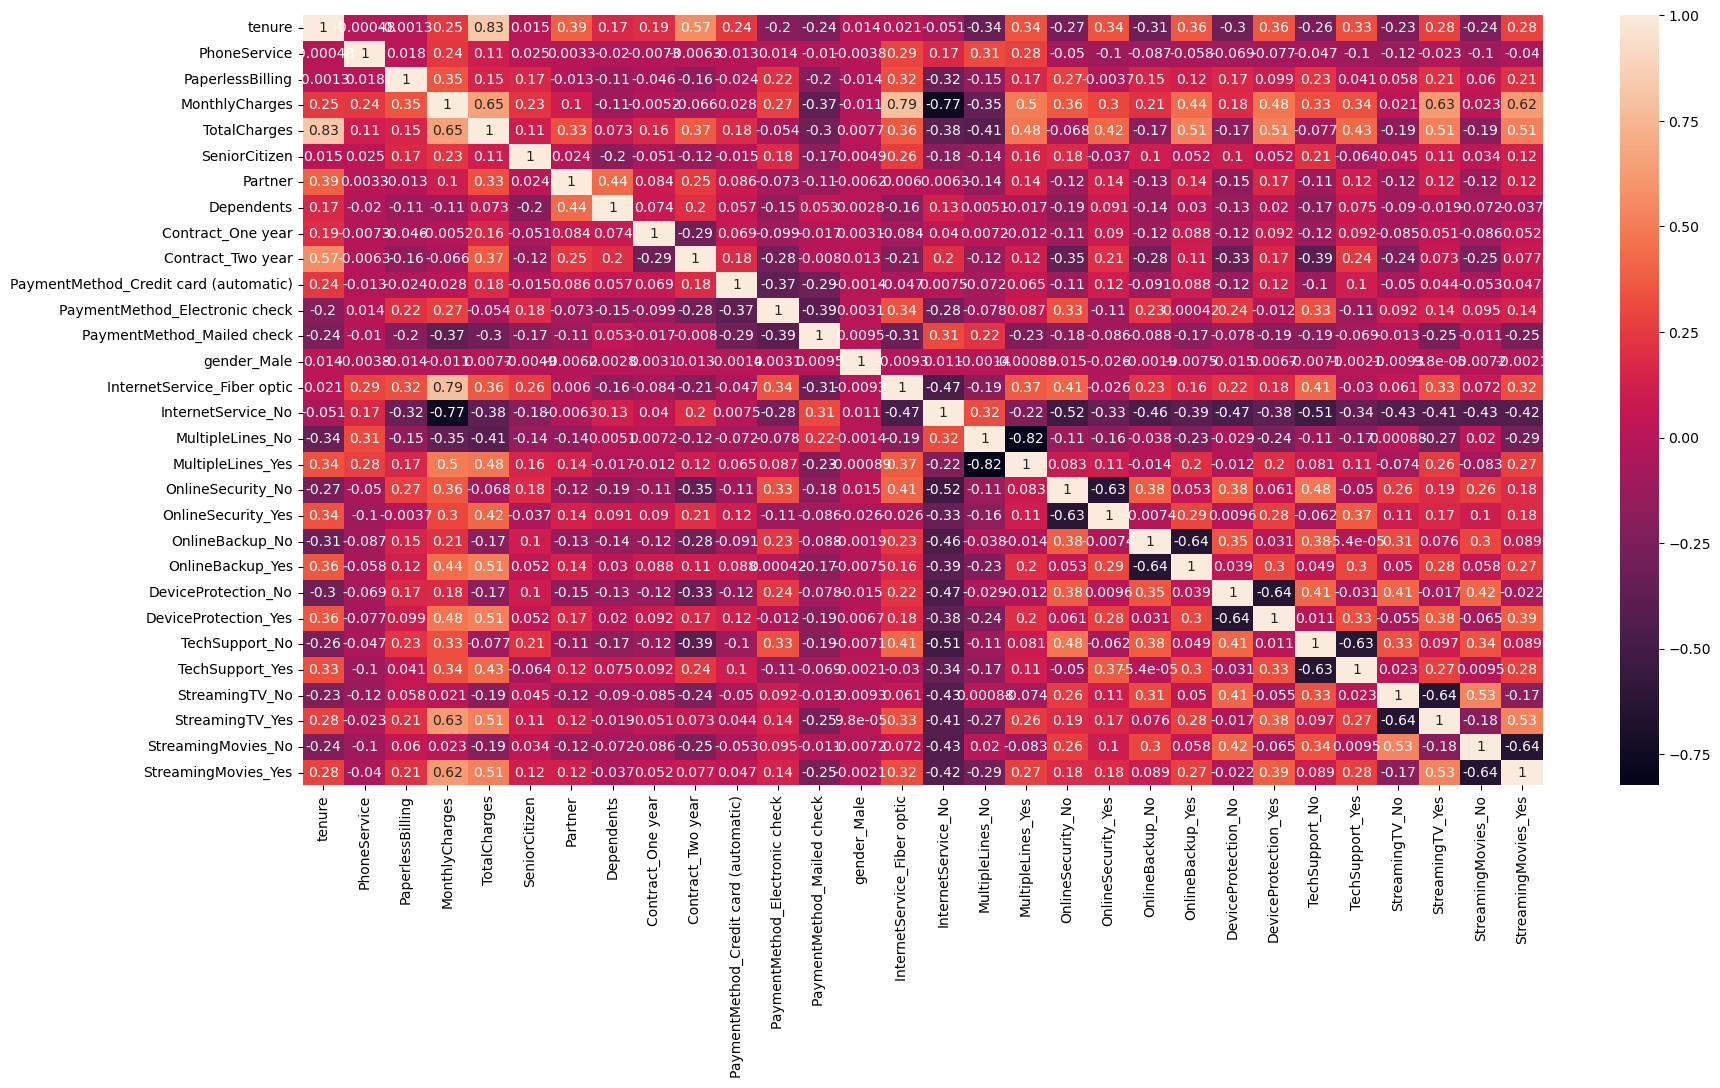

In [28]:
# plot correlations 

plt.figure(figsize=(20, 10))
sns.heatmap(X_train.corr(), annot = True)
plt.show()

In [29]:
# drop columns with high correlations

high_corr_vars = ['MultipleLines_No', 'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 
                  'StreamingTV_No', 'StreamingMovies_No']

X_train = X_train.drop(columns=high_corr_vars, axis = 1)

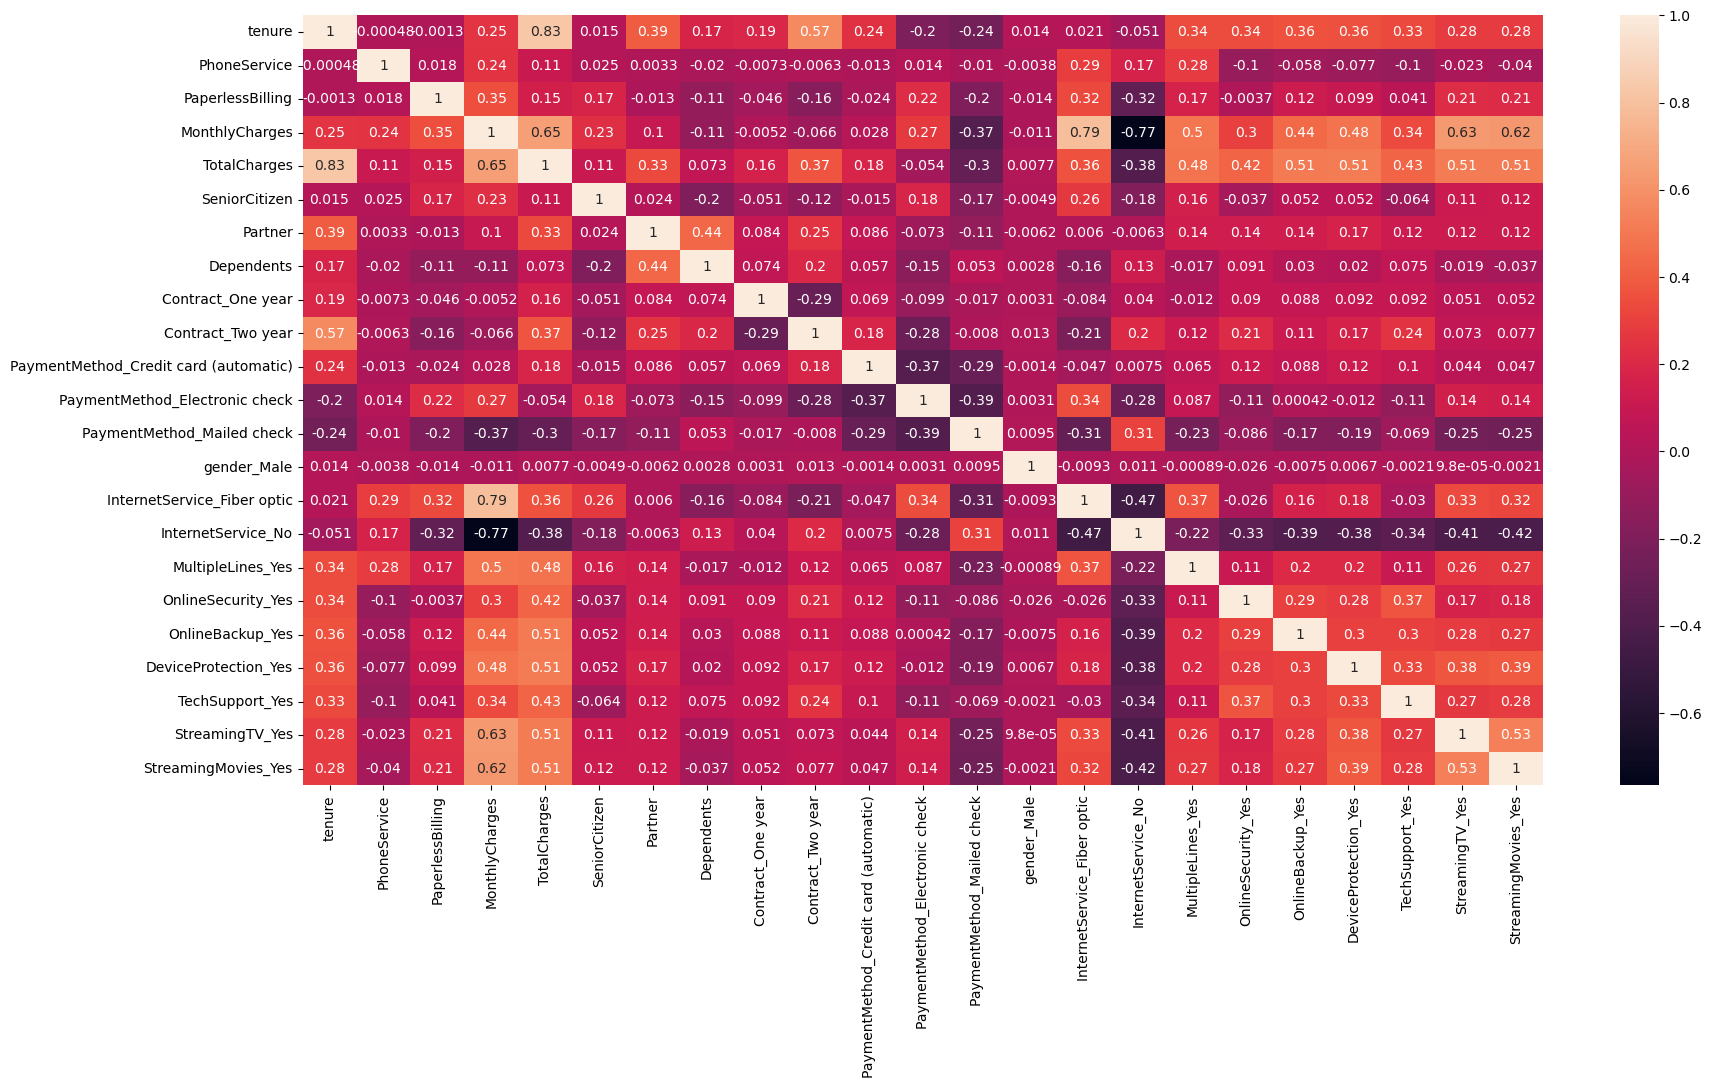

In [30]:
# plot correlations again

plt.figure(figsize=(20, 10))
sns.heatmap(X_train.corr(), annot = True)
plt.show()

In [31]:
# model-1 with all variables

X_train_sm = sm.add_constant(X_train)
log_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
log_model = log_model.fit()

In [32]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Sat, 06 Apr 2024   Deviance:                       4009.4
Time:                        12:37:21   Pearson chi2:                 6.07e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2844
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.9382      1.546     -2.547      0.011      -6.969      -0.908
tenure                                   -1.5172      0.189     -8.015      0.000      -1.888      -1.146
PhoneService                              0.9507      0.789      1.205      0.228      -0.595       2.497
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
MonthlyCharges                           -2.1806      1.160     -1.880      0.060      -4.454       0.092
TotalCharges                              0.7332      0.198      3.705      0.000       0.345       1.121
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -2.7792      0.982     -2.831      0.005      -4.703      -0.855
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_Yes                       0.8484      0.396      2.143      0.032       0.072       1.624
=========================================================================================================
"""

### Feature selection with RFE

In [33]:
# feature selection

lg = LogisticRegression()

rfe = RFE(lg, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [34]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('tenure', True, 1),
 ('PhoneService', False, 3),
 ('PaperlessBilling', True, 1),
 ('MonthlyCharges', True, 1),
 ('TotalCharges', True, 1),
 ('SeniorCitizen', True, 1),
 ('Partner', False, 7),
 ('Dependents', False, 6),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaymentMethod_Credit card (automatic)', True, 1),
 ('PaymentMethod_Electronic check', False, 4),
 ('PaymentMethod_Mailed check', True, 1),
 ('gender_Male', False, 8),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', True, 1),
 ('MultipleLines_Yes', True, 1),
 ('OnlineSecurity_Yes', False, 2),
 ('OnlineBackup_Yes', False, 5),
 ('DeviceProtection_Yes', False, 9),
 ('TechSupport_Yes', True, 1),
 ('StreamingTV_Yes', True, 1),
 ('StreamingMovies_Yes', True, 1)]

In [35]:
X_train.columns[~rfe.support_]

Index(['PhoneService', 'Partner', 'Dependents',
       'PaymentMethod_Electronic check', 'gender_Male', 'OnlineSecurity_Yes',
       'OnlineBackup_Yes', 'DeviceProtection_Yes'],
      dtype='object')

In [36]:
# update X_train with selected variables

cols = X_train.columns[rfe.support_]
X_train = X_train[cols]

In [37]:
# build model-2 

X_train_sm = sm.add_constant(X_train)
log_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
log_model = log_model.fit()

In [38]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4906
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.1
Date:                Sat, 06 Apr 2024   Deviance:                       4022.2
Time:                        12:37:21   Pearson chi2:                 6.25e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2825
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2462      0.189    -11.879      0.000      -2.617      -1.876
tenure                                   -1.5596      0.187     -8.334      0.000      -1.926      -1.193
PaperlessBilling                          0.3436      0.090      3.832      0.000       0.168       0.519
MonthlyCharges                           -0.9692      0.199     -4.878      0.000      -1.359      -0.580
TotalCharges                              0.7421      0.197      3.764      0.000       0.356       1.128
SeniorCitizen                             0.4296      0.100      4.312      0.000       0.234       0.625
Contract_One year                        -0.6830      0.128     -5.342      0.000      -0.934      -0.432
Contract_Two year                        -1.2931      0.211     -6.138      0.000      -1.706      -0.880
PaymentMethod_Credit card (automatic)    -0.3724      0.113     -3.308      0.001      -0.593      -0.152
PaymentMethod_Mailed check               -0.3723      0.111     -3.345      0.001      -0.591      -0.154
InternetService_Fiber optic               1.5865      0.216      7.342      0.000       1.163       2.010
InternetService_No                       -1.6897      0.216     -7.830      0.000      -2.113      -1.267
MultipleLines_Yes                         0.3779      0.104      3.640      0.000       0.174       0.581
TechSupport_Yes                          -0.2408      0.109     -2.210      0.027      -0.454      -0.027
StreamingTV_Yes                           0.5796      0.114      5.102      0.000       0.357       0.802
StreamingMovies_Yes                       0.4665      0.111      4.197      0.000       0.249       0.684
=========================================================================================================
"""

In [39]:
# define vif utility

def compute_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range (0, len(X.columns))]
    vif = vif.sort_values(by = 'VIF', ascending=False)
    return vif

In [40]:
y_train_pred = log_model.predict(X_train_sm)

In [41]:
# compute prediction

y_train_pred_df = pd.DataFrame({'Churn_Actual':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_df['CustID'] = y_train.index
y_train_pred_df['Churn_Predicted'] = y_train_pred_df.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0) # 0.5 is randomly choosen
y_train_pred_df.head()

,Churn_Actual,Churn_Prob,CustID,Churn_Predicted
879,0,0.192642,879,0
5790,0,0.275624,5790,0
6498,1,0.599507,6498,1
880,1,0.513571,880,1
2784,1,0.648233,2784,1


In [42]:
# construct confuision matrix

mat = confusion_matrix(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
mat

array([[3275,  360],
       [ 574,  713]], dtype=int64)

In [43]:
# determine accuracy of the model

acc = accuracy_score(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
round(acc, 3)

0.81

Model accuracy is 81% but we can not rely on this, we have to check for multicollinearity.

In [44]:
# multicollinearity detection with vif

vif = compute_vif(X_train)
vif

,Features,VIF
2,MonthlyCharges,14.848268
3,TotalCharges,10.418581
0,tenure,7.378458
9,InternetService_Fiber optic,5.607472
10,InternetService_No,5.271052
6,Contract_Two year,3.144732
14,StreamingMovies_Yes,2.792727
13,StreamingTV_Yes,2.791697
1,PaperlessBilling,2.756535
11,MultipleLines_Yes,2.375806


There are high vif values are present in the model, so we have to remove them.

In [45]:
# model 3 remove 'MonthlyCharges'

X_train = X_train.drop(columns=['MonthlyCharges'], axis = 1)
X_train_sm = sm.add_constant(X_train)
log_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4907
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.1
Date:                Sat, 06 Apr 2024   Deviance:                       4046.2
Time:                        12:37:22   Pearson chi2:                 5.80e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2790
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5971      0.130    -12.296      0.000      -1.852      -1.343
tenure                                   -1.3286      0.180     -7.401      0.000      -1.681      -0.977
PaperlessBilling                          0.3533      0.089      3.958      0.000       0.178       0.528
TotalCharges                              0.4347      0.186      2.340      0.019       0.071       0.799
SeniorCitizen                             0.4569      0.099      4.601      0.000       0.262       0.652
Contract_One year                        -0.7289      0.127     -5.729      0.000      -0.978      -0.480
Contract_Two year                        -1.3277      0.210     -6.322      0.000      -1.739      -0.916
PaymentMethod_Credit card (automatic)    -0.3870      0.112     -3.442      0.001      -0.607      -0.167
PaymentMethod_Mailed check               -0.3618      0.110     -3.274      0.001      -0.578      -0.145
InternetService_Fiber optic               0.6888      0.109      6.297      0.000       0.474       0.903
InternetService_No                       -0.9555      0.156     -6.120      0.000      -1.262      -0.649
MultipleLines_Yes                         0.1700      0.094      1.814      0.070      -0.014       0.354
TechSupport_Yes                          -0.4371      0.101     -4.307      0.000      -0.636      -0.238
StreamingTV_Yes                           0.2881      0.096      2.996      0.003       0.100       0.477
StreamingMovies_Yes                       0.1944      0.096      2.031      0.042       0.007       0.382
=========================================================================================================
"""

all p-values are less than 0.05 and hence all the coefficients are significant.

In [46]:
# predictions

y_train_pred = log_model.predict(X_train_sm)
y_train_pred_df = pd.DataFrame({'Churn_Actual': y_train, 'Churn_Prob': y_train_pred, 'CustId': y_train.index})
y_train_pred_df['Churn_Predicted'] = y_train_pred_df['Churn_Prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_df.head()

,Churn_Actual,Churn_Prob,CustId,Churn_Predicted
879,0,0.227902,879,0
5790,0,0.228644,5790,0
6498,1,0.674892,6498,1
880,1,0.615868,880,1
2784,1,0.662260,2784,1


In [47]:
# construct confuision matrix

mat = confusion_matrix(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
mat

array([[3269,  366],
       [ 590,  697]], dtype=int64)

In [48]:
# check accuracy
acc = accuracy_score(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
round(acc, 3)

0.806

In [49]:
# compute vif

vif = compute_vif(X_train)
vif

,Features,VIF
2,TotalCharges,7.459381
0,tenure,6.898971
5,Contract_Two year,3.070035
8,InternetService_Fiber optic,2.959871
13,StreamingMovies_Yes,2.616502
12,StreamingTV_Yes,2.589761
1,PaperlessBilling,2.550472
9,InternetService_No,2.443707
10,MultipleLines_Yes,2.274276
11,TechSupport_Yes,1.949484


In [50]:
# model 4 drop MultipleLines_Yes

X_train = X_train.drop(columns=['MultipleLines_Yes'], axis = 1)
X_train_sm = sm.add_constant(X_train)
log_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4908
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2024.8
Date:                Sat, 06 Apr 2024   Deviance:                       4049.5
Time:                        12:37:22   Pearson chi2:                 5.88e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2785
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5390      0.126    -12.238      0.000      -1.785      -1.293
tenure                                   -1.3489      0.179     -7.527      0.000      -1.700      -0.998
PaperlessBilling                          0.3602      0.089      4.037      0.000       0.185       0.535
TotalCharges                              0.4932      0.183      2.697      0.007       0.135       0.852
SeniorCitizen                             0.4655      0.099      4.701      0.000       0.271       0.660
Contract_One year                        -0.7459      0.127     -5.877      0.000      -0.995      -0.497
Contract_Two year                        -1.3430      0.210     -6.392      0.000      -1.755      -0.931
PaymentMethod_Credit card (automatic)    -0.3864      0.112     -3.440      0.001      -0.607      -0.166
PaymentMethod_Mailed check               -0.3703      0.110     -3.353      0.001      -0.587      -0.154
InternetService_Fiber optic               0.7172      0.108      6.615      0.000       0.505       0.930
InternetService_No                       -0.9545      0.156     -6.110      0.000      -1.261      -0.648
TechSupport_Yes                          -0.4426      0.101     -4.365      0.000      -0.641      -0.244
StreamingTV_Yes                           0.2868      0.096      2.983      0.003       0.098       0.475
StreamingMovies_Yes                       0.1935      0.096      2.023      0.043       0.006       0.381
=========================================================================================================
"""

In [51]:
# predictions

y_train_pred = log_model.predict(X_train_sm)
y_train_pred_df = pd.DataFrame({'Churn_Actual': y_train, 'Churn_Prob': y_train_pred, 'CustId': y_train.index})
y_train_pred_df['Churn_Predicted'] = y_train_pred_df['Churn_Prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_df.head()

,Churn_Actual,Churn_Prob,CustId,Churn_Predicted
879,0,0.207224,879,0
5790,0,0.237572,5790,0
6498,1,0.688443,6498,1
880,1,0.632758,880,1
2784,1,0.675609,2784,1


In [52]:
# construct confuision matrix

mat = confusion_matrix(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
mat

array([[3264,  371],
       [ 596,  691]], dtype=int64)

In [53]:
# check accuracy
acc = accuracy_score(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
round(acc, 3)

0.804

In [54]:
# compute vif

vif = compute_vif(X_train)
vif

,Features,VIF
2,TotalCharges,7.352100
0,tenure,6.898966
5,Contract_Two year,3.053155
8,InternetService_Fiber optic,2.695795
12,StreamingMovies_Yes,2.608754
11,StreamingTV_Yes,2.586963
1,PaperlessBilling,2.494542
9,InternetService_No,2.398655
10,TechSupport_Yes,1.946646
4,Contract_One year,1.791095


In [55]:
# model 5 drop TotalCharges

X_train = X_train.drop(columns=['TotalCharges'], axis = 1)
X_train_sm = sm.add_constant(X_train)
log_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4909
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2028.5
Date:                Sat, 06 Apr 2024   Deviance:                       4057.1
Time:                        12:37:22   Pearson chi2:                 5.25e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2774
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5953      0.123    -12.944      0.000      -1.837      -1.354
tenure                                   -0.9025      0.062    -14.475      0.000      -1.025      -0.780
PaperlessBilling                          0.3528      0.089      3.959      0.000       0.178       0.527
SeniorCitizen                             0.4711      0.099      4.741      0.000       0.276       0.666
Contract_One year                        -0.7415      0.126     -5.874      0.000      -0.989      -0.494
Contract_Two year                        -1.3118      0.208     -6.303      0.000      -1.720      -0.904
PaymentMethod_Credit card (automatic)    -0.3867      0.112     -3.439      0.001      -0.607      -0.166
PaymentMethod_Mailed check               -0.3362      0.110     -3.070      0.002      -0.551      -0.122
InternetService_Fiber optic               0.8626      0.094      9.169      0.000       0.678       1.047
InternetService_No                       -0.9718      0.155     -6.257      0.000      -1.276      -0.667
TechSupport_Yes                          -0.4058      0.101     -4.032      0.000      -0.603      -0.208
StreamingTV_Yes                           0.3458      0.094      3.695      0.000       0.162       0.529
StreamingMovies_Yes                       0.2496      0.093      2.675      0.007       0.067       0.432
=========================================================================================================
"""

In [56]:
# predictions

y_train_pred = log_model.predict(X_train_sm)
y_train_pred_df = pd.DataFrame({'Churn_Actual': y_train, 'Churn_Prob': y_train_pred, 'CustId': y_train.index})
y_train_pred_df['Churn_Predicted'] = y_train_pred_df['Churn_Prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_df.head()

,Churn_Actual,Churn_Prob,CustId,Churn_Predicted
879,0,0.220918,879,0
5790,0,0.284383,5790,0
6498,1,0.685902,6498,1
880,1,0.654550,880,1
2784,1,0.702684,2784,1


In [57]:
# construct confuision matrix

mat = confusion_matrix(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
mat

array([[3270,  365],
       [ 604,  683]], dtype=int64)

In [58]:
# check accuracy
acc = accuracy_score(y_true = y_train_pred_df['Churn_Actual'], y_pred = y_train_pred_df['Churn_Predicted'])
round(acc, 3)

0.803

In [59]:
# compute vif

vif = compute_vif(X_train)
vif

,Features,VIF
4,Contract_Two year,2.967015
11,StreamingMovies_Yes,2.527988
10,StreamingTV_Yes,2.501893
1,PaperlessBilling,2.414582
7,InternetService_Fiber optic,2.328525
8,InternetService_No,2.008970
0,tenure,1.967931
9,TechSupport_Yes,1.916922
3,Contract_One year,1.775121
6,PaymentMethod_Mailed check,1.629650


Model 5 is our final model, with accuracy of 80.3%

### Model evaluation 

Accuracy is not enough to determine the goodness of model. We will define 2 new metric, sensitivity and specificity.

In [60]:
# actual     predicted
#            no churn   churn 
# no churn   TN          FN
# churn      FP          TP

$$ sensitivity = \frac{TP}{TP+FP} $$

$$ specificity = \frac{TN}{TN+FN} $$

In [61]:
# compute sensitivity and specificity

TN = mat[0][0]
FN = mat[0][1]
FP = mat[1][0]
TP = mat[1][1]

𝑠𝑒𝑛𝑠𝑖𝑡𝑖𝑣𝑖𝑡𝑦 = 𝑇𝑃 / (𝑇𝑃+𝐹𝑃)
𝑠𝑝𝑒𝑐𝑖𝑓𝑖𝑐𝑖𝑡𝑦 = 𝑇𝑁 / (𝑇𝑁+𝐹𝑁)

print('sensitivity = ', round(𝑠𝑒𝑛𝑠𝑖𝑡𝑖𝑣𝑖𝑡𝑦, 3))
print('specificity = ', round(𝑠𝑝𝑒𝑐𝑖𝑓𝑖𝑐𝑖𝑡𝑦, 3))

sensitivity =  0.531
specificity =  0.9


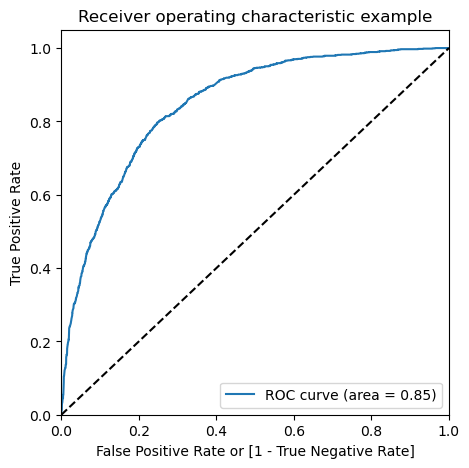

In [62]:
# draw roc-curve

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

draw_roc(y_train_pred_df['Churn_Actual'], y_train_pred_df['Churn_Prob'])

**Interpretation from ROC curve**

- fpr = 1-specificity
- tpr = sensitivity

- $$tpr ∝ fpr$$

- $$sensitivity ∝ \frac{1}{specificity}$$

- higher the area under the curve is higher the good model is.

### Find the optimal threshold

In [63]:
# compute probabality in all thresholds from 0 to 1

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_train_pred_df = pd.DataFrame()
y_train_pred_df['Churn_Act'] = y_train
y_train_pred_df['Prob'] = y_train_pred

for i in range(0, len(thresholds)):
    idx = '{}'.format(thresholds[i])
    y_train_pred_df[idx] = y_train_pred_df['Prob'].map(lambda x: 1 if x > thresholds[i] else 0)
    
y_train_pred_df

,Churn_Act,Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
879,0,0.220918,1,1,1,0,0,0,0,0,0,0,0
5790,0,0.284383,1,1,1,0,0,0,0,0,0,0,0
6498,1,0.685902,1,1,1,1,1,1,1,0,0,0,0
880,1,0.654550,1,1,1,1,1,1,1,0,0,0,0
2784,1,0.702684,1,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0,0.021831,1,0,0,0,0,0,0,0,0,0,0
3934,0,0.095406,1,0,0,0,0,0,0,0,0,0,0
5964,0,0.068610,1,0,0,0,0,0,0,0,0,0,0
6947,0,0.097988,1,0,0,0,0,0,0,0,0,0,0


In [64]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

for i in thresholds:
    idx = '{}'.format(i)
    accuracy = accuracy_score(y_true = y_train_pred_df['Churn_Act'], y_pred = y_train_pred_df[idx])
    mat = confusion_matrix(y_true = y_train_pred_df['Churn_Act'], y_pred = y_train_pred_df[idx])
    
    TN = mat[0][0]
    FP = mat[0][1]
    FN = mat[1][0]
    TP = mat[1][1]

    sensi = 𝑇𝑃 / (𝑇𝑃+𝐹N)
    speci = 𝑇𝑁 / (𝑇𝑁+𝐹P)
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

cutoff_df

,prob,accuracy,sensi,speci
0.0,0.0,0.261479,1.000000,0.000000
0.1,0.1,0.617838,0.944833,0.502063
0.2,0.2,0.723283,0.850039,0.678404
0.3,0.3,0.769200,0.776224,0.766713
0.4,0.4,0.790532,0.635587,0.845392
0.5,0.5,0.803129,0.530692,0.899587
0.6,0.6,0.800284,0.388500,0.946080
0.7,0.7,0.776920,0.193473,0.983494
0.8,0.8,0.745835,0.034188,0.997799
0.9,0.9,0.738521,0.000000,1.000000


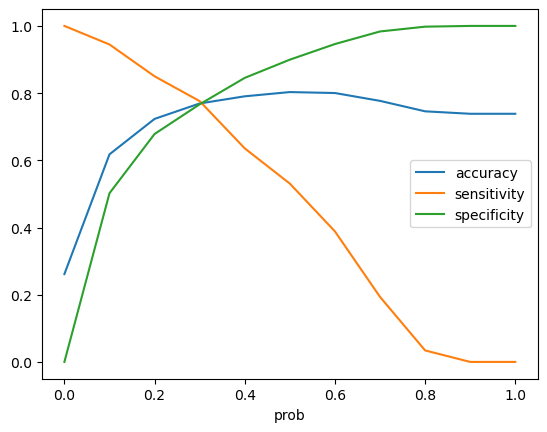

In [65]:
# plot the metrics

plt.plot(cutoff_df['accuracy'], label = 'accuracy')
plt.plot(cutoff_df['sensi'], label = 'sensitivity')
plt.plot(cutoff_df['speci'], label = 'specificity')
plt.xlabel('prob')
plt.legend(loc='best')

plt.show()

they all are intersecting at 0.3, so 0.3 can be a optimal cutoff. Using `cutoff_df` we can say that the accuracy of the model on trained set is 77%, sensitivity is 77.6% and specificity is 76.6%.

### Some other metrics for model evaluation

Apart from **sensitivity** and **specificity**, we have 2 more metrics for model evaluation. These are as following

- Precision
- Recall

These metric will be useful in case of detection (e.g. fraud detection). Precision and Recall is defined as

$$ Precision = \frac{TP}{TP+FP} $$

$$ Recall = \frac{TP}{TP+FN} $$

**Notes**

- Recall is same as Sensitivity.
- Precision: Probability that a predicted 'Yes' is actually a 'Yes'.
- Recall:  Probability that an actual 'Yes' case is predicted correctly.


### Optimal threshold using Precision and Recall

In [66]:
cutoff_df2 = pd.DataFrame( columns = ['prob','accuracy','recall','precision'])

for i in thresholds:
    idx = '{}'.format(i)
    accuracy = accuracy_score(y_true = y_train_pred_df['Churn_Act'], y_pred = y_train_pred_df[idx])
    mat = confusion_matrix(y_true = y_train_pred_df['Churn_Act'], y_pred = y_train_pred_df[idx])
    
    TN = mat[0][0]
    FP = mat[0][1]
    FN = mat[1][0]
    TP = mat[1][1]

    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    cutoff_df2.loc[i] =[ i ,accuracy,recall,precision]

cutoff_df2

,prob,accuracy,recall,precision
0.0,0.0,0.261479,1.000000,0.261479
0.1,0.1,0.617838,0.944833,0.401851
0.2,0.2,0.723283,0.850039,0.483429
0.3,0.3,0.769200,0.776224,0.540877
0.4,0.4,0.790532,0.635587,0.592754
0.5,0.5,0.803129,0.530692,0.651718
0.6,0.6,0.800284,0.388500,0.718391
0.7,0.7,0.776920,0.193473,0.805825
0.8,0.8,0.745835,0.034188,0.846154
0.9,0.9,0.738521,0.000000,NaN


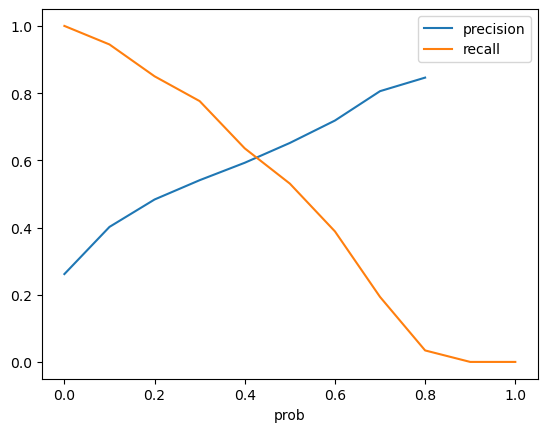

In [68]:
# plot the metrics

plt.plot(cutoff_df2['precision'], label = 'precision')
plt.plot(cutoff_df2['recall'], label = 'recall')
plt.xlabel('prob')
plt.legend(loc='best')

plt.show()

In [69]:
p, r, thresholds = precision_recall_curve(y_true = y_train_pred_df['Churn_Act'] , probas_pred= y_train_pred_df['Prob'])

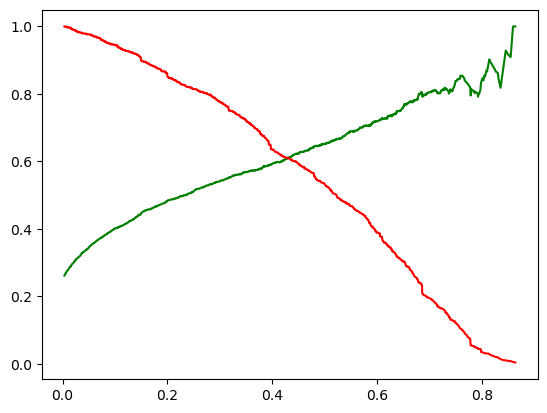

In [70]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

With this metric the threshold value is 0.42

### Predictions on test set

In [71]:
# construct X_test and y_test

test_data[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(test_data[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_test = test_data[X_train.columns]
y_test = test_data['Churn']

In [72]:
# predictions

X_test_sm = sm.add_constant(X_test)
y_test_pred = log_model.predict(X_test_sm)
y_test_pred_df = pd.DataFrame({'Churn_Actual': y_test, 'Churn_Prob': y_test_pred, 'CustId': y_test.index})
y_test_pred_df['Churn_Predicted'] = y_test_pred_df['Churn_Prob'].map(lambda x: 1 if x > 0.3 else 0)
y_test_pred_df.head()

,Churn_Actual,Churn_Prob,CustId,Churn_Predicted
942,0,0.449353,942,1
3730,1,0.254817,3730,0
1761,0,0.007756,1761,0
2283,1,0.609418,2283,1
1872,0,0.014900,1872,0


In [73]:
# check accuracy
acc = accuracy_score(y_true = y_test_pred_df['Churn_Actual'], y_pred = y_test_pred_df['Churn_Predicted'])
round(acc, 3)

0.741

In [74]:
con_mat2 = confusion_matrix(y_true = y_test_pred_df['Churn_Actual'], y_pred = y_test_pred_df['Churn_Predicted'])
con_mat2

array([[1144,  384],
       [ 163,  419]], dtype=int64)

In [75]:
tn = con_mat2[0][0]
fp = con_mat2[0][1]
fn = con_mat2[1][0]
tp = con_mat2[1][1]

In [76]:
sensitivity_test = tp/(tp+fn)
sensitivity_test

0.7199312714776632

In [77]:
specificity = tn/(tn+fp)
specificity

0.7486910994764397